# Model Selection
Model selection is a critical step in the modeling procedure where you compare, evaluate, and choose the best predictive model from a set of candidates. The goal of model selection is to identify the model that will perform best on future data, not just the training set. The process typically involves:
- Comparing different algorithms (e.g., linear regression, decision trees, random forests, etc.).
- Tuning model hyperparameters to optimize performance.
- Using statistical criteria (such as AIC, BIC, or adjusted R²) and/or validation metrics (such as accuracy, RMSE, ROC-AUC) to assess model quality.
- Employing cross-validation or holdout validation to estimate how well each model generalizes to new, unseen data.
- Selecting the model that best balances predictive accuracy, interpretability, and complexity for your specific problem.

## Initialization

In [44]:
import pandas as pd
import numpy as np
import os
import rich

In [45]:
version_tag = "dev"

## Load Data

In [46]:
input_folder = "../.local/analysis_pipeline/data_exploration"
model_data = pd.read_parquet(f"{input_folder}/model_data_{version_tag}.parquet")
print(model_data.shape)

(15000, 29)


In [47]:
# Load the selected IDs
selected_ids = pd.read_csv("../.local/selected_data_identifiers.csv")['id']

# Filter model_data to keep only rows with IDs in selected_ids
model_data = model_data[model_data['id'].isin(selected_ids)].copy()
print(model_data.shape)

(9916, 29)


## Build Model
This is the base model of our project

In [48]:
# Compute the capped claim amount per exposure
model_data['claim_amt_capped_per_exposure'] = model_data['claim_amt_capped'] / model_data['exposure']

In [ ]:
# Define the list of predictors
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'high_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst # Split the data into training and validation sets
# pred_lst = ['engine_type', 'gender', 'credit_score', 'veh_age', 'agecat', 'area']

train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(7398, 30)
(2518, 30)

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,high_education_ind,clm,claim_cnt,claim_amt,veh_cnt,data_segment,claim_sev,claim_sev_capped,claim_amt_capped,claim_amt_capped_per_exposure
1,2,3,1|bld,1.90,0.632068,STNWG,4,M,A,2,...,0.0,1,1,360.017223,1,1|model,360.017223,360.017223,360.017223,569.585954
2,3,1,1|bld,1.67,0.367460,HBACK,2,M,C,2,...,0.0,1,1,202.114407,1,1|model,202.114407,202.114407,202.114407,550.030713
5,6,2,1|bld,3.01,0.945653,PANVN,1,M,C,1,...,1.0,1,1,421.631012,1,1|model,421.631012,421.631012,421.631012,445.862279
6,7,3,1|bld,1.14,0.853331,HDTOP,4,M,C,2,...,1.0,1,1,405.860245,1,1|model,405.860245,405.860245,405.860245,475.618562
7,8,1,1|bld,1.41,0.648295,HBACK,1,F,A,4,...,0.0,1,1,352.785509,1,1|model,352.785509,352.785509,352.785509,544.174568


In [50]:
# XGBoost Tweedie Regression with Cross-Validation Early Stopping and Native Categorical Support
import xgboost as xgb

# Define features and target
y = train_data['claim_amt_capped_per_exposure']
X = train_data[pred_lst].copy()
# weights = train_data['exposure']  # Assuming exposure is in years, convert to months

# Convert object columns to pandas Categorical dtype for XGBoost native categorical support
for col in pred_lst:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# XGBoost DMatrix with offset
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

# # Compute offset (log of exposure, or any other offset variable)
# offset = np.log(train_data['exposure'])
# dtrain.set_base_margin(offset)

# Define XGBoost parameters for Tweedie regression
params = {
    'objective': 'reg:tweedie',         # Tweedie regression objective
    'tweedie_variance_power': 1.5,      # Tweedie power (1=Poisson, 2=Gamma, 1<p<2 for insurance)
    'learning_rate': 0.01,              # Step size shrinkage (smaller = more robust, slower learning)
    'max_depth': 5,                     # Maximum tree depth (controls model complexity)
    'min_child_weight': 100,            # Minimum sum of instance weight (hessian) needed in a child (min samples per leaf, set for 45,300 samples)
    'subsample': 0.8,                   # Fraction of samples used per tree (prevents overfitting)
    'colsample_bytree': 0.8,            # Fraction of features used per tree (prevents overfitting)
    'lambda': 1.0,                      # L2 regularization term (prevents overfitting)
    'alpha': 0.0,                       # L1 regularization term (prevents overfitting)
    'nthread': -1,                      # Use all CPU cores
    'seed': 42                          # Random seed for reproducibility
}

# Cross-validation with early stopping
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=5000,
    nfold=5,  # 5-fold cross-validation
    metrics='rmse',  # or another appropriate metric
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
 )

# The best number of boosting rounds is:
best_num_boost_round = len(cv_results)
print(f"Best num_boost_round from CV: {best_num_boost_round}")

# Train final model on all data using best_num_boost_round
model = xgb.train(
    params,
    dtrain,
    # num_boost_round=500
    num_boost_round=best_num_boost_round
 )

[0]	train-rmse:389.21371+8.08640	test-rmse:388.23605+31.30827


[50]	train-rmse:384.45385+7.90863	test-rmse:387.46048+31.62924
[100]	train-rmse:380.58110+7.74505	test-rmse:387.32482+31.72226
[100]	train-rmse:380.58110+7.74505	test-rmse:387.32482+31.72226
[144]	train-rmse:377.44919+7.63272	test-rmse:387.33772+31.78053
[144]	train-rmse:377.44919+7.63272	test-rmse:387.33772+31.78053
Best num_boost_round from CV: 95
Best num_boost_round from CV: 95


C:\Users\mengjin6\AppData\Local\Temp\ipykernel_38544\4158606199.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pred_per_exposure'] = train_pred
C:\Users\mengjin6\AppData\Local\Temp\ipykernel_38544\4158606199.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['pred'] = train_data['pred_per_exposure'] * train_data['exposure']  # Scale by exposure
C:\Users\mengjin6\AppData\Local\Temp\ipykernel_38544\4158606199.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy 

1.467973534964581


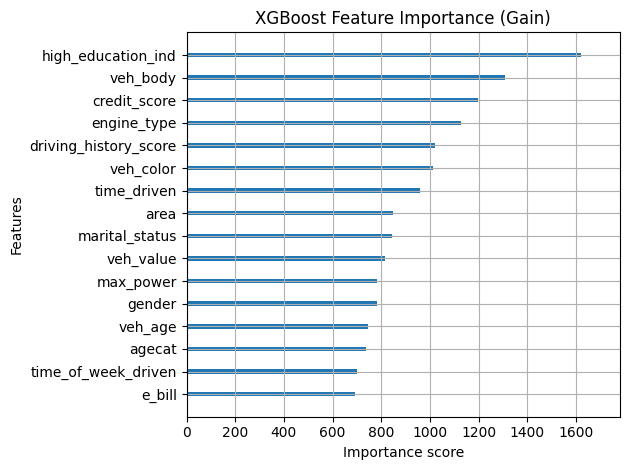

In [51]:
# Model Fitting Score and Prediction ---
# Prepare train and validation data for prediction
X_train = train_data[pred_lst].copy()
X_val = val_data[pred_lst].copy()

# Convert object columns to category for both sets
for col in pred_lst:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
    if X_val[col].dtype == 'object':
        X_val[col] = X_val[col].astype('category')

# In-sample fitted values
dtrain_pred = xgb.DMatrix(X_train, enable_categorical=True)
train_pred = model.predict(dtrain_pred)
train_data['pred_per_exposure'] = train_pred 
train_data['pred'] = train_data['pred_per_exposure'] * train_data['exposure']  # Scale by exposure
rescale_factor_2 = train_data['claim_amt_capped'].sum() / train_data['pred'].sum()
print(rescale_factor_2)
train_data['pred_rescale'] = train_data['pred'] * rescale_factor_2

# Out-of-sample prediction on validation set
dval_pred = xgb.DMatrix(X_val, enable_categorical=True)
val_pred = model.predict(dval_pred)
val_data['pred_per_exposure'] = val_pred
val_data['pred'] = val_data['pred_per_exposure'] * val_data['exposure']  # Scale by exposure
val_data['pred_rescale'] = val_data['pred'] * rescale_factor_2

# --- Variable Importance Plot ---
import matplotlib.pyplot as plt
xgb.plot_importance(model, importance_type='gain', show_values=False, title='XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

In [57]:
### Load Base Model Into Memory
output_folder = "../.local/analysis_pipeline/model_selection"
os.makedirs(output_folder, exist_ok=True)
model.save_model(f"{output_folder}/xgb_tweedie_model_{version_tag}.json")

## Model Evaluation
Below please find resources on different model evaluation metrics:
1. Gini coefficient: The Gini coefficient is a statistical measure of inequality, but in the context of the Casualty Actuarial Society (CAS), it is used to evaluate the effectiveness of predictive models, such as those used for insurance ratemaking. In this application, a Gini index measures how well a model's predictions (like for pure premium or risk scores) distinguish between high-risk and low-risk policyholders, with a higher Gini coefficient indicating better model performance. (Source: Search "Gini coefficient Casualty Actuarial Society").
2. https://www.casact.org/sites/default/files/presentation/rpm_2019_presentations_m-4_williams.pdf

### On training data

Top Lift: 3.6622
Gini: 0.6863
R^2: 0.0862
RMSE: 215.07
MAE: 81.73


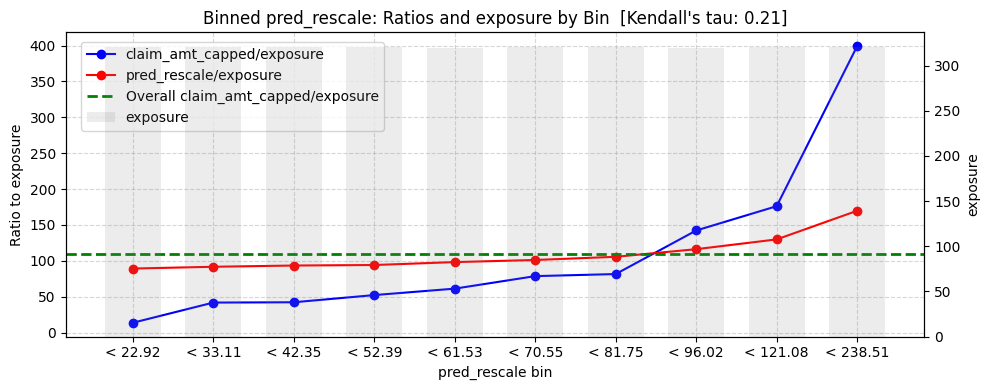

In [53]:
# Ensure the parent directory is in the path for module import
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

# Select training samples for predictiveness check
data = train_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claim_amt_capped'
var_2 = 'pred_rescale'
nbins = 10


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute R^2, RMSE, and MAE
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
r2 = me.r2()
rmse = me.rmse()
mae = me.mae()

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
pc.plot(figsize=(10, 4))


### On validation data

Top Lift: 1.6131
Gini: 0.5379
R^2: 0.0287
RMSE: 230.51
MAE: 75.06


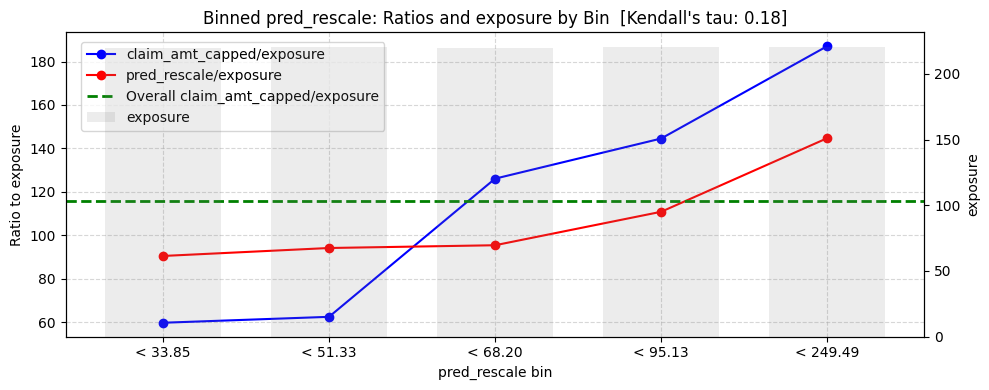

In [59]:
# Select validation sample for predictiveness check
data = val_data

# Define variables
exp_var = 'exposure'
pred_var = 'pred_rescale'
var_1 = 'claim_amt_capped'
var_2 = 'pred_rescale'
nbins = 5


# Create and run PredictivenessCheck
pc = PredictivenessCheck(
    df=data,
    pred_var=pred_var,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2
)

pc.binning(nbins=nbins)
pc.aggregate()

# Compute top lift
pc.top_lift()

# Compute R^2, RMSE, and MAE
var_2 = 'pred'
me = ModelEvaluation(data[var_1], data[var_2])
gini = me.gini()
r2 = me.r2()
rmse = me.rmse()
mae = me.mae()

# Print results
print(f"Top Lift: {pc.top_lift:.4f}")
print(f"Gini: {gini:.4f}")
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
pc.plot(figsize=(10, 4))

## Predict Vs Actual Check
### On training data


--- Predictiveness Plot for veh_value ---


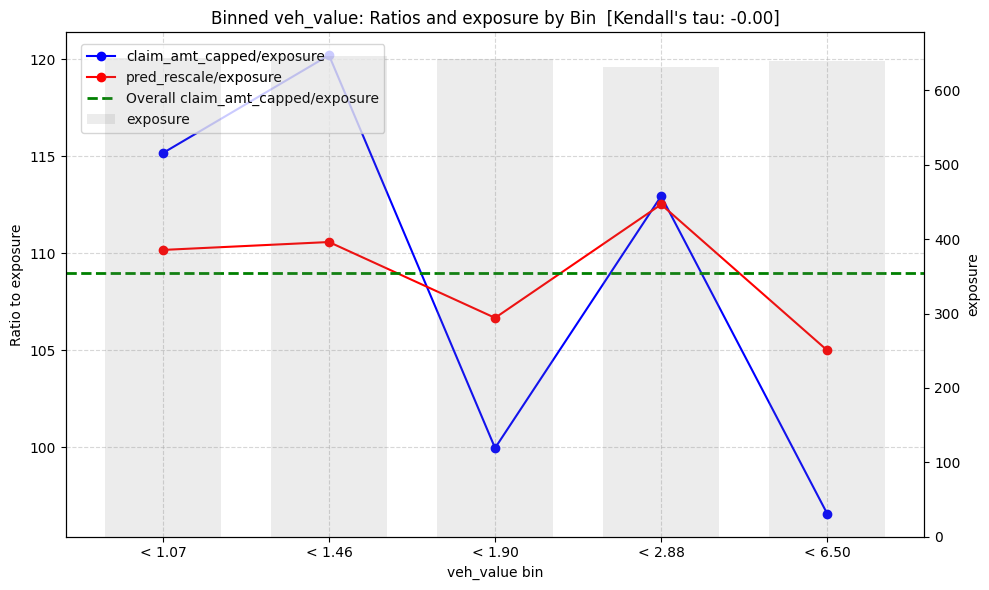


--- Predictiveness Plot for veh_body ---


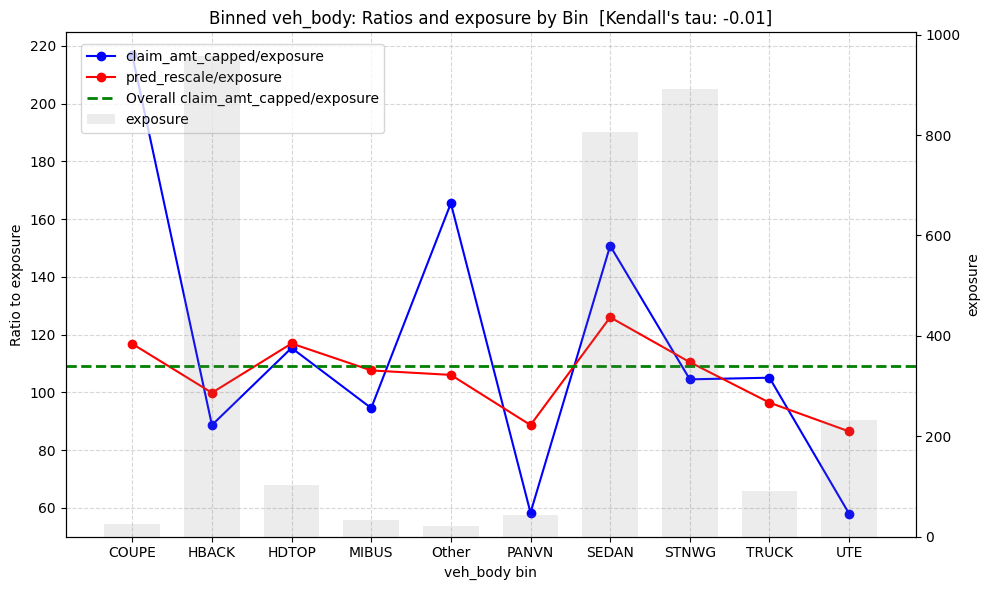


--- Predictiveness Plot for veh_age ---


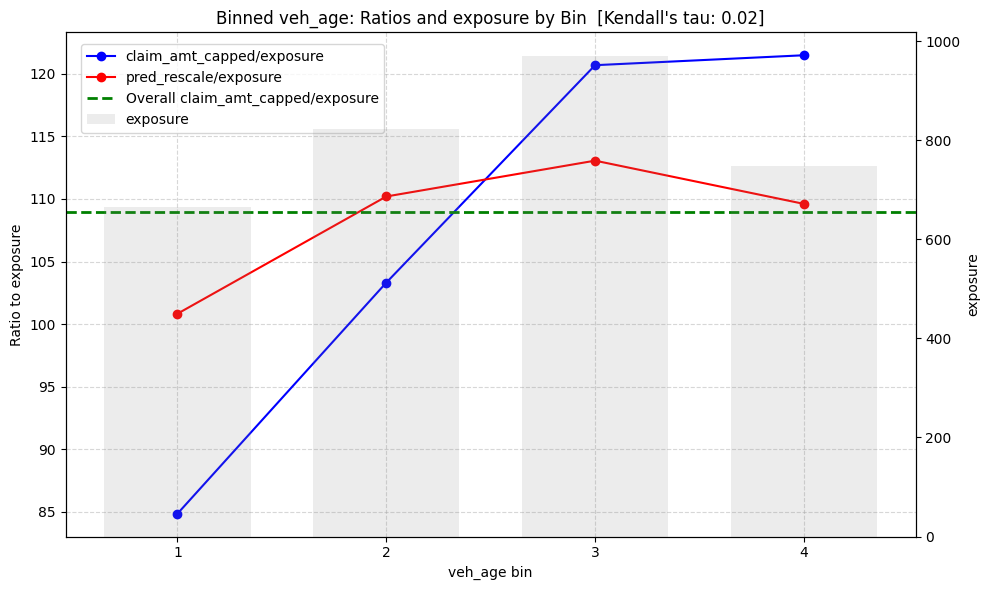


--- Predictiveness Plot for engine_type ---


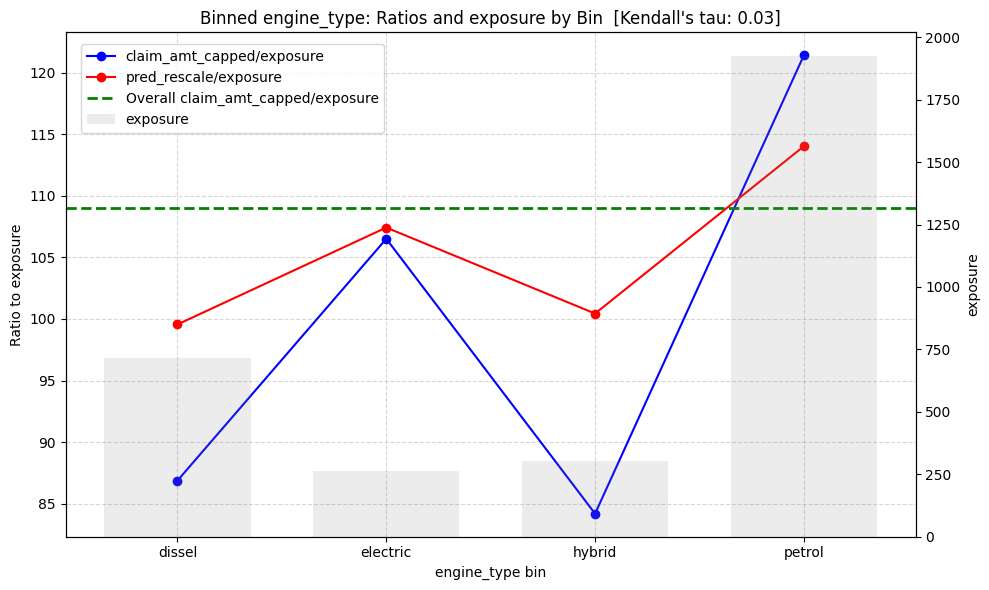


--- Predictiveness Plot for max_power ---


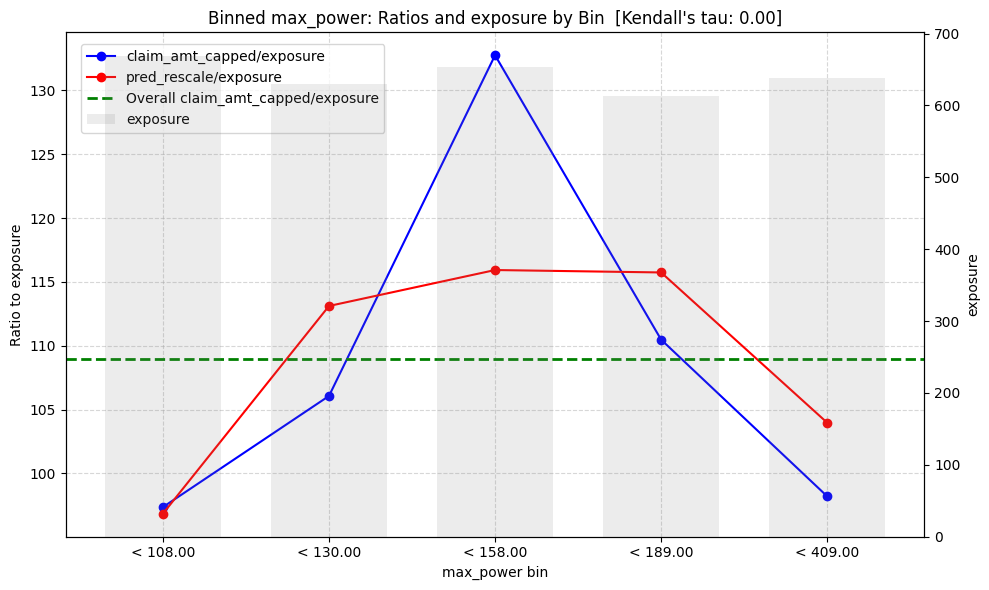


--- Predictiveness Plot for veh_color ---


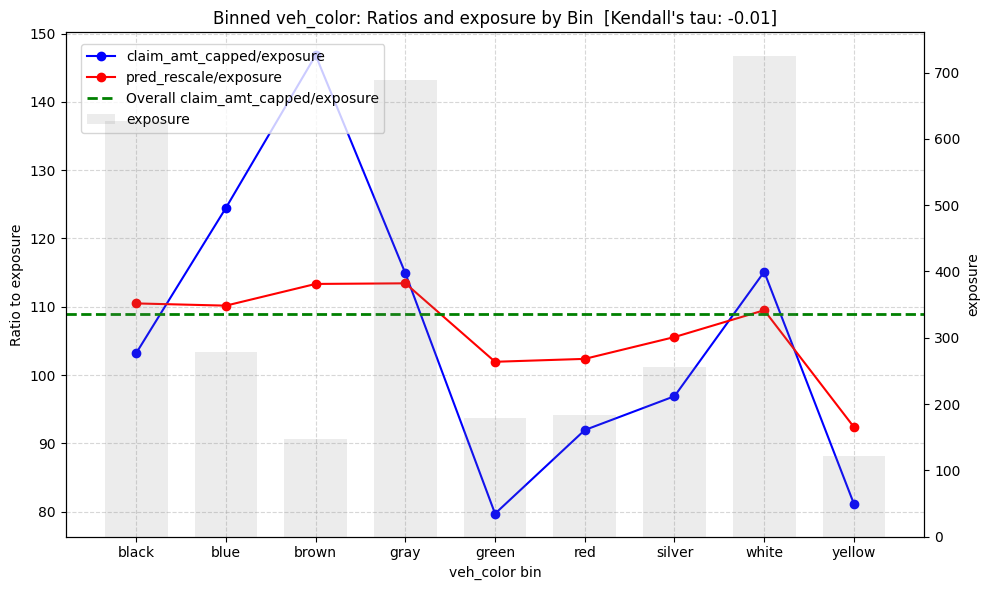


--- Predictiveness Plot for gender ---


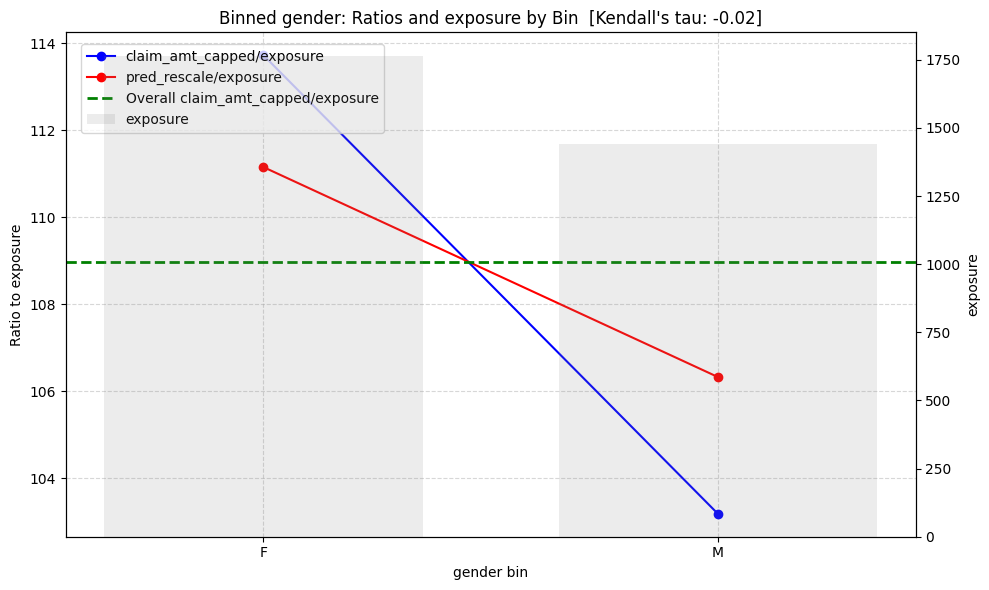


--- Predictiveness Plot for agecat ---


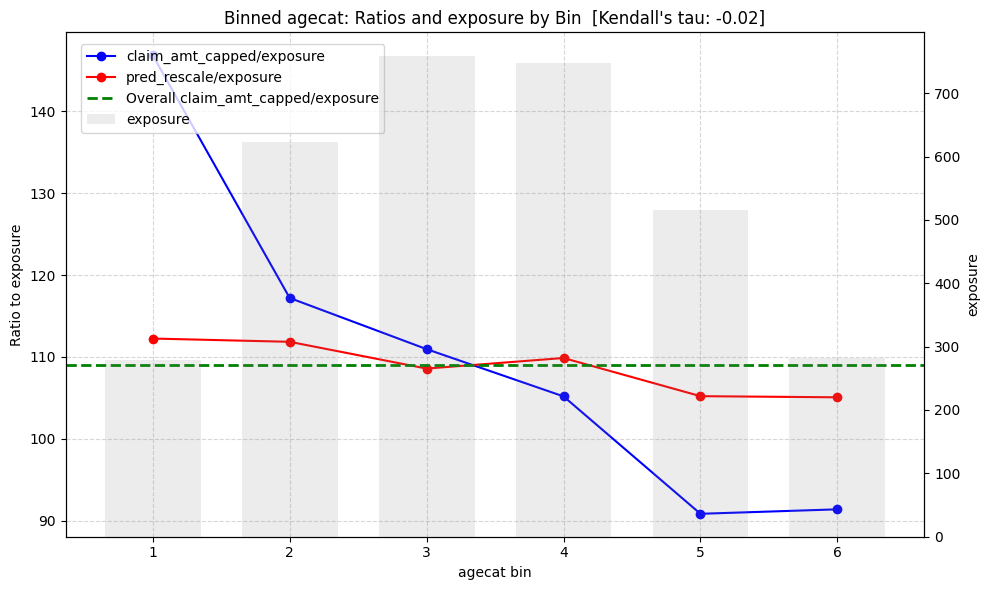


--- Predictiveness Plot for e_bill ---


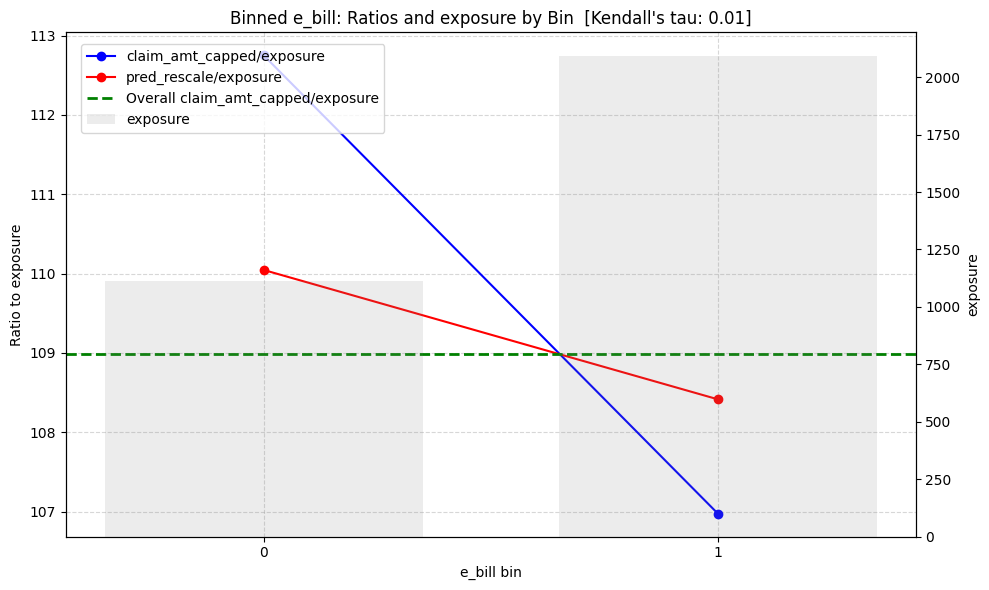


--- Predictiveness Plot for area ---


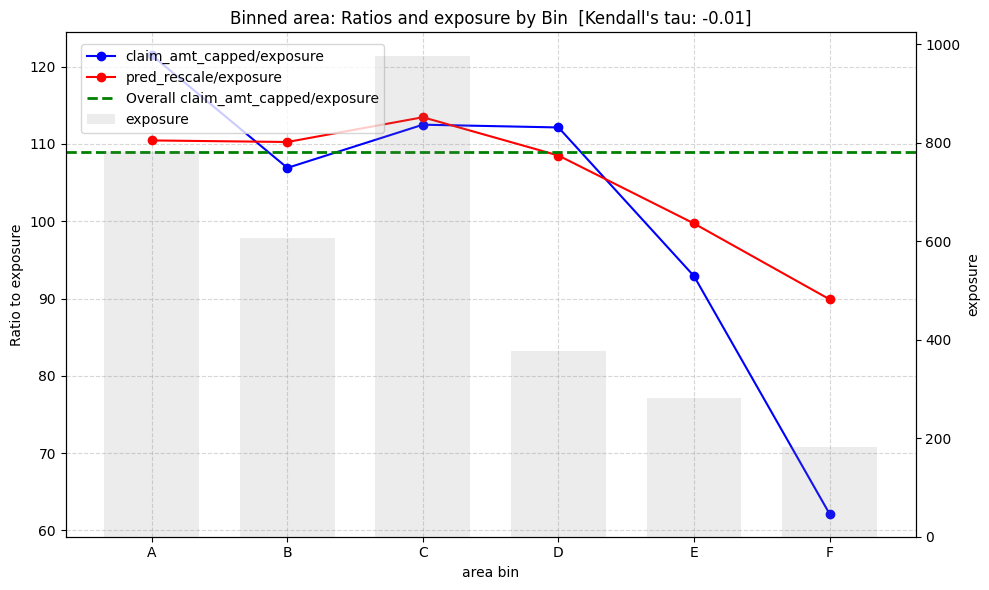


--- Predictiveness Plot for time_of_week_driven ---


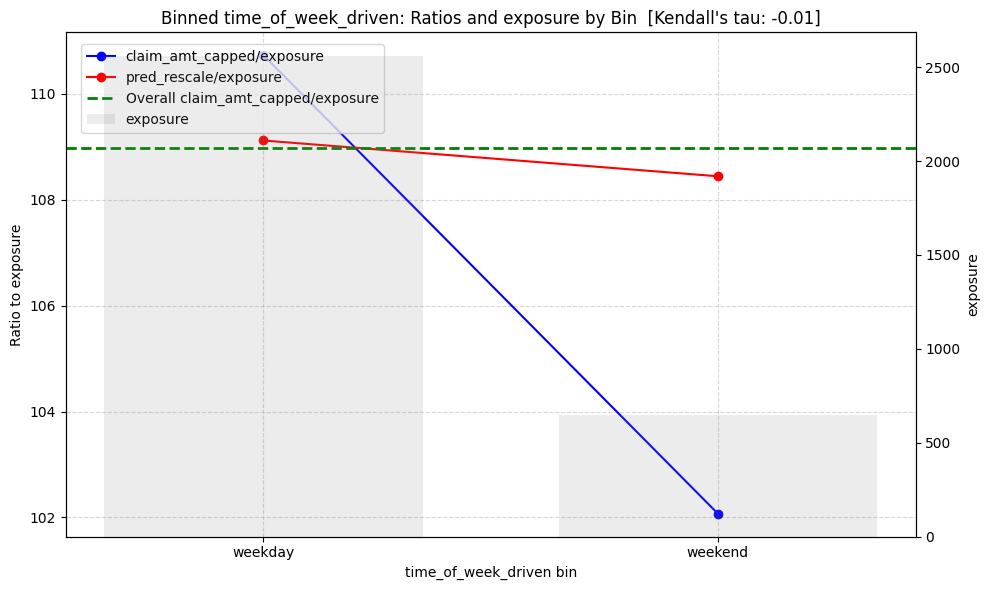


--- Predictiveness Plot for time_driven ---


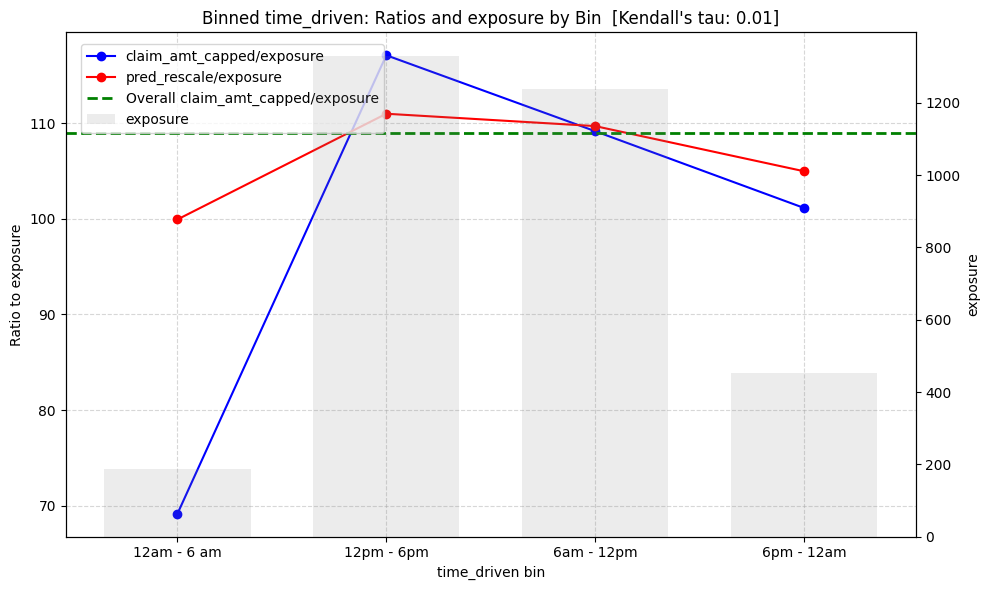


--- Predictiveness Plot for marital_status ---


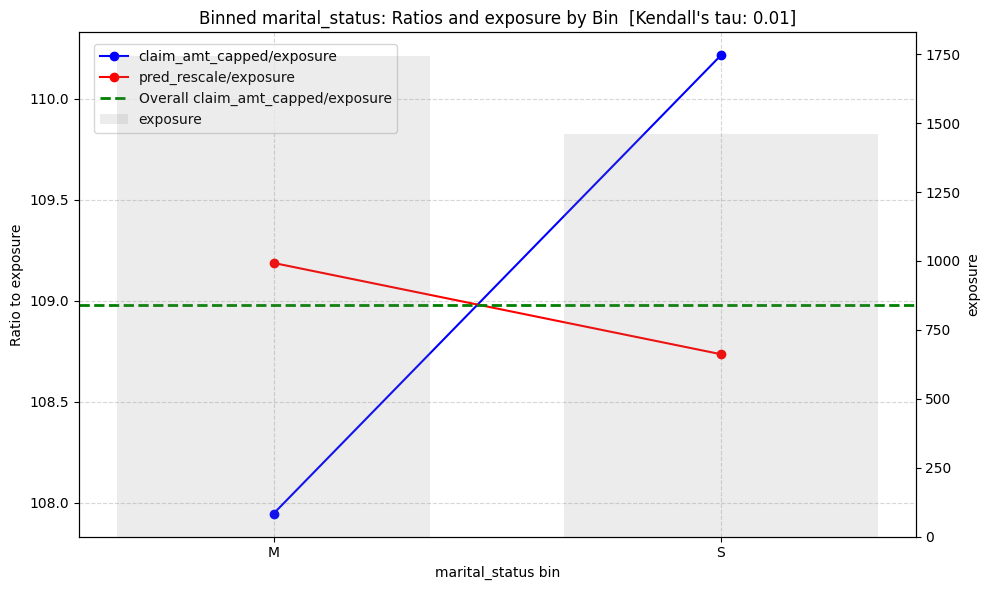


--- Predictiveness Plot for high_education_ind ---


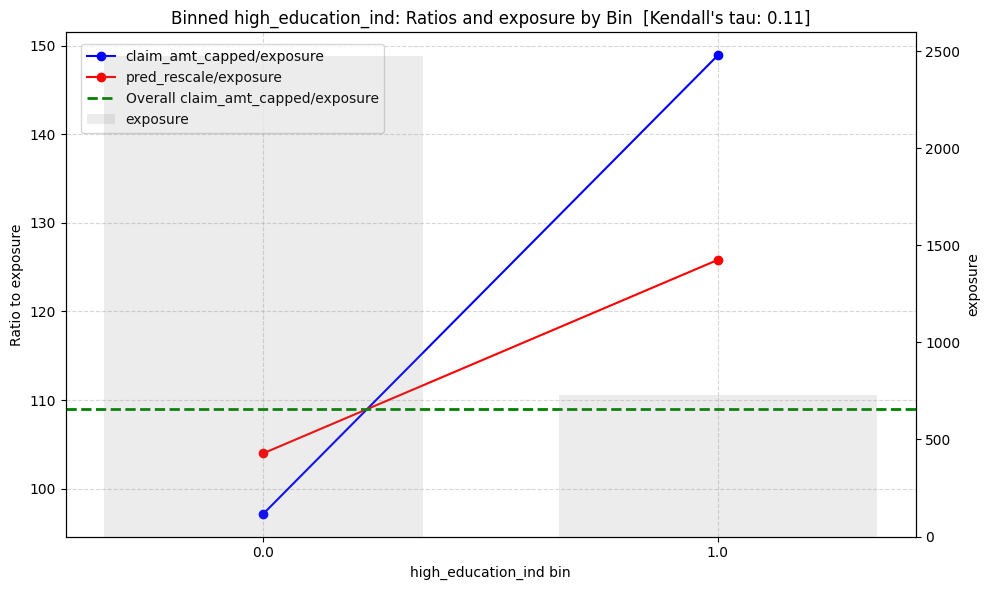


--- Predictiveness Plot for credit_score ---


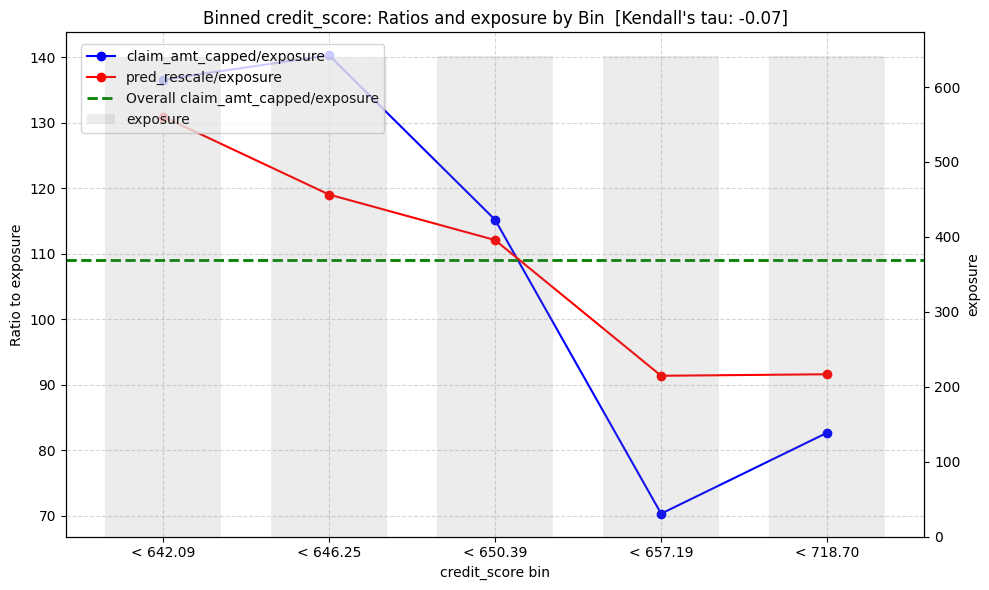


--- Predictiveness Plot for driving_history_score ---


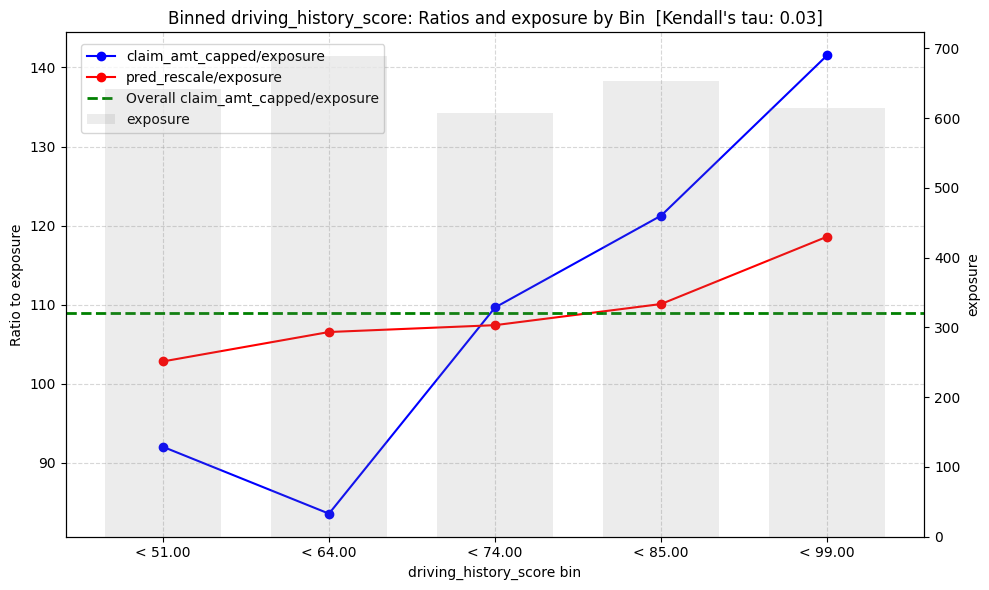

In [55]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
exp_var = 'exposure' 
var_1 = 'claim_amt_capped'     
var_2 = 'pred_rescale'   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=train_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

### On validation data


--- Predictiveness Plot for veh_value ---


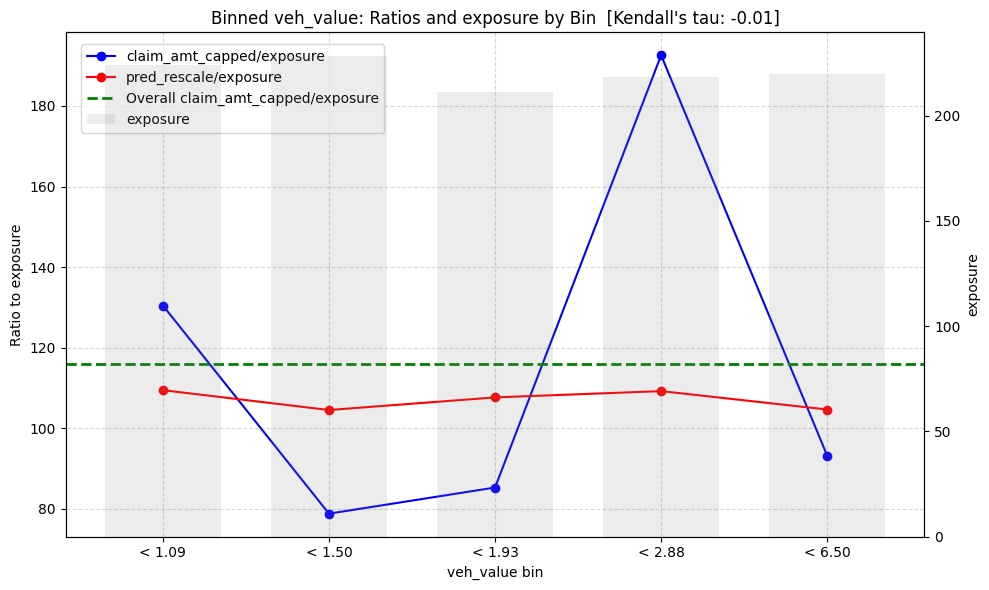


--- Predictiveness Plot for veh_body ---


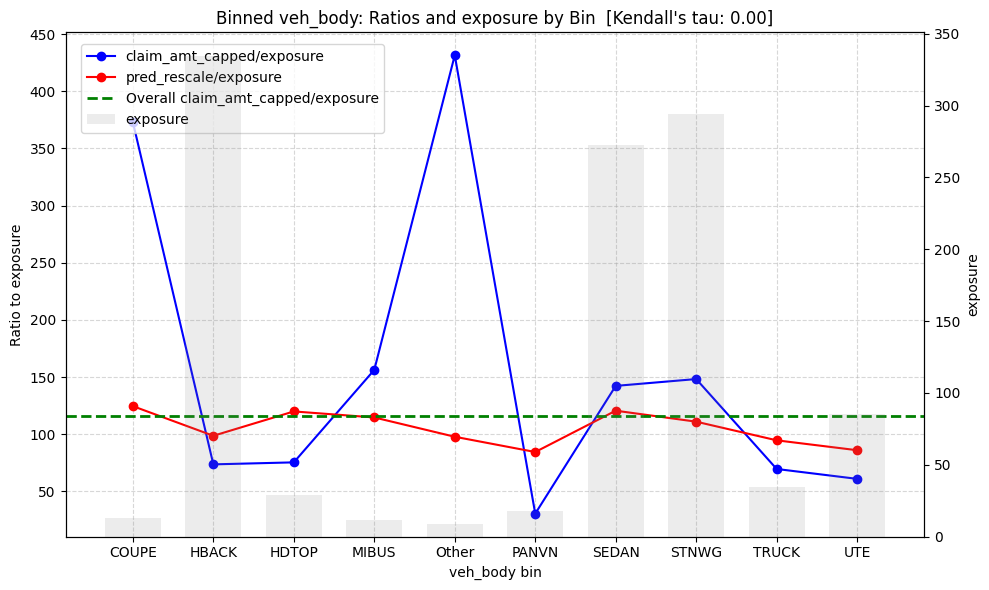


--- Predictiveness Plot for veh_age ---


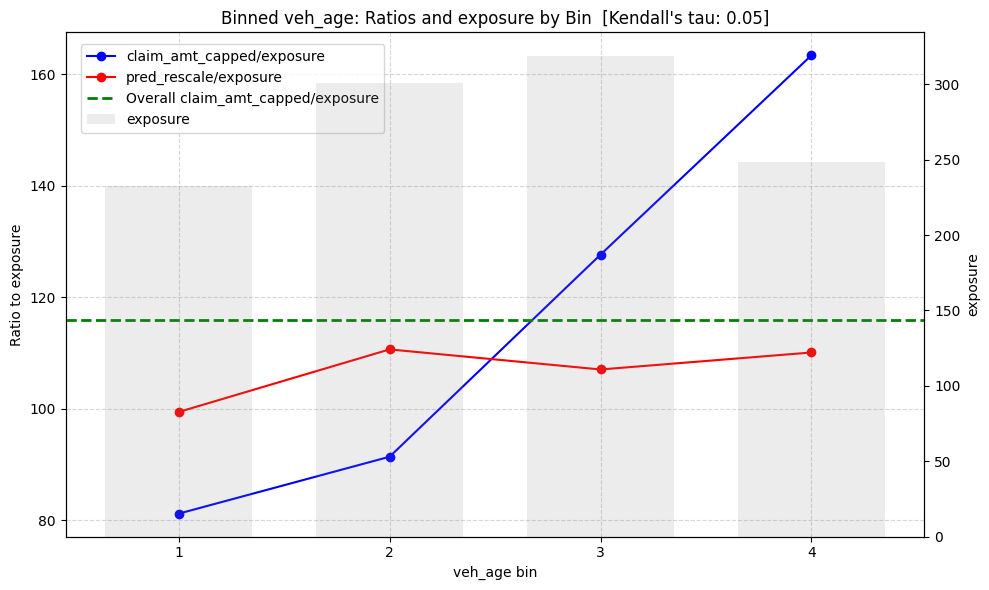


--- Predictiveness Plot for engine_type ---


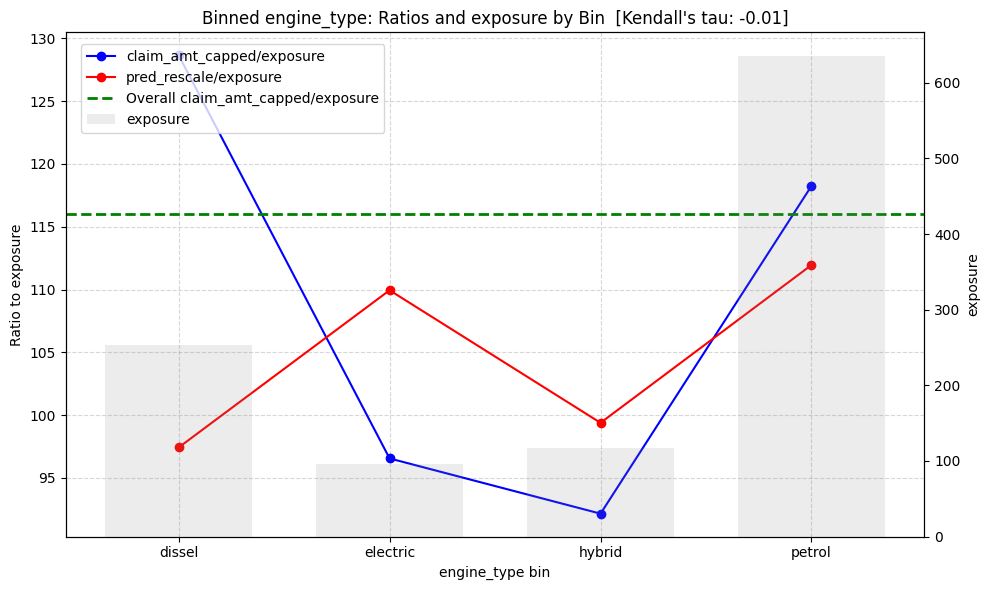


--- Predictiveness Plot for max_power ---


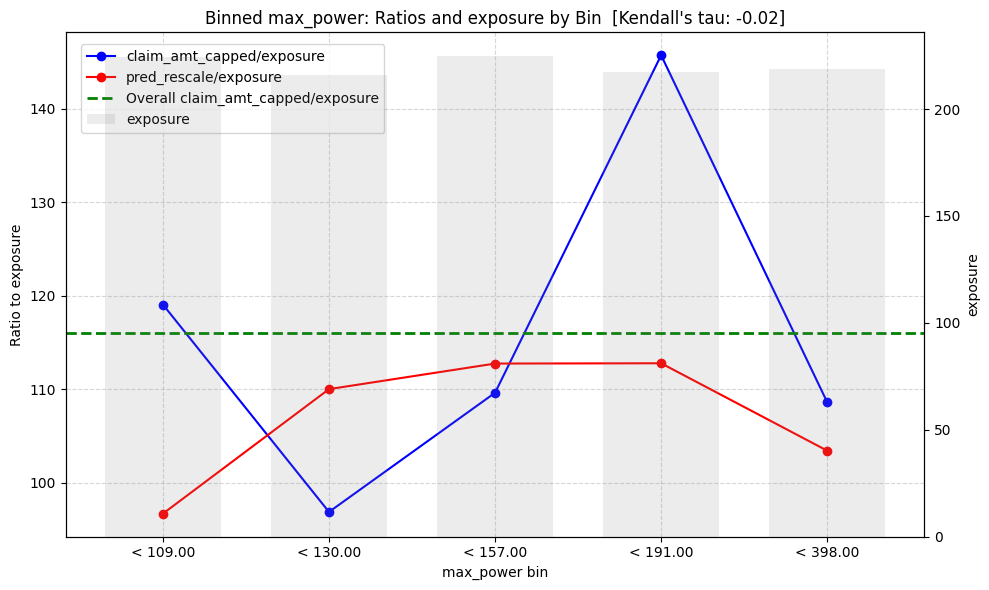


--- Predictiveness Plot for veh_color ---


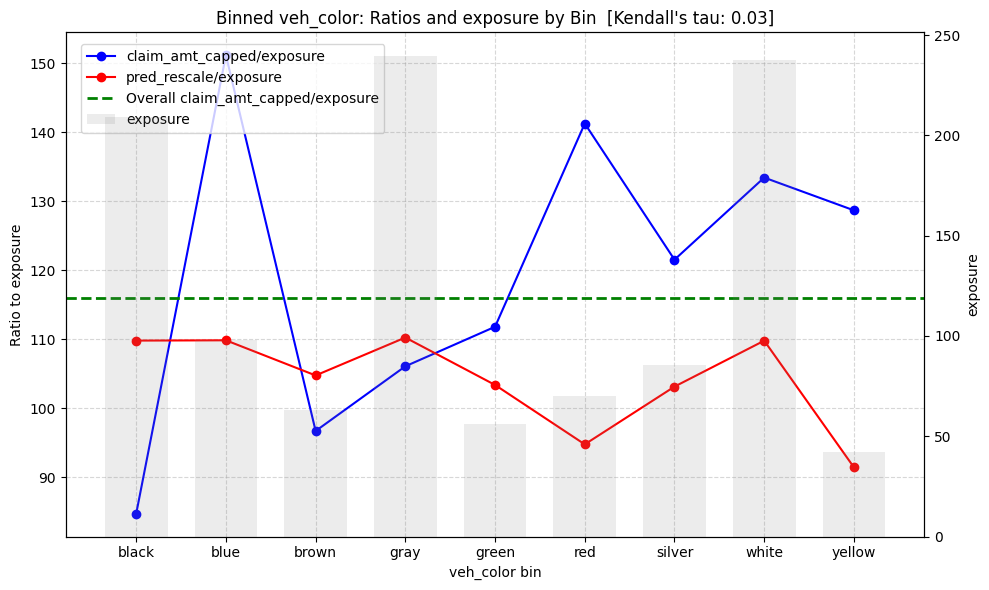


--- Predictiveness Plot for gender ---


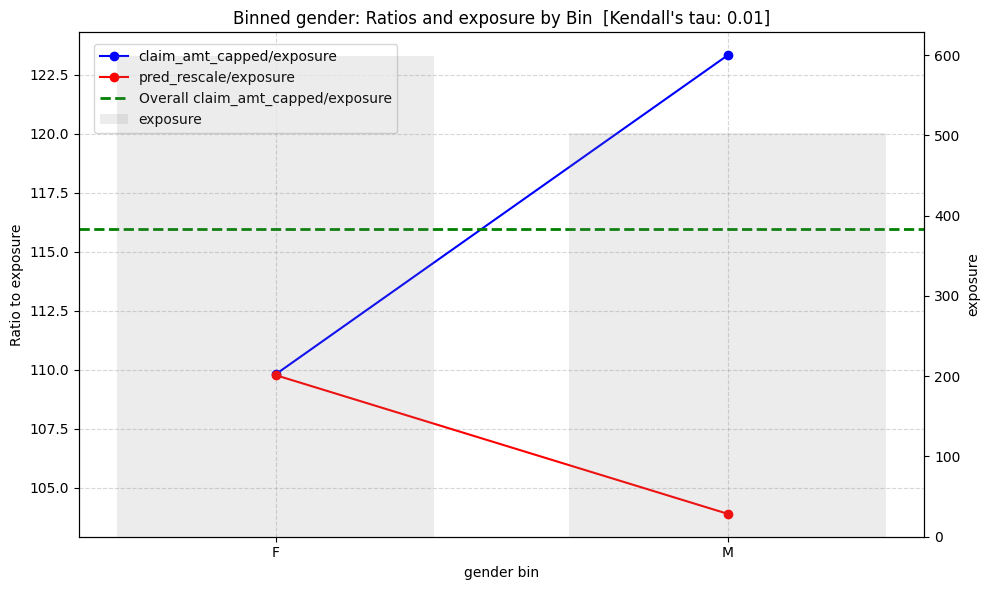


--- Predictiveness Plot for agecat ---


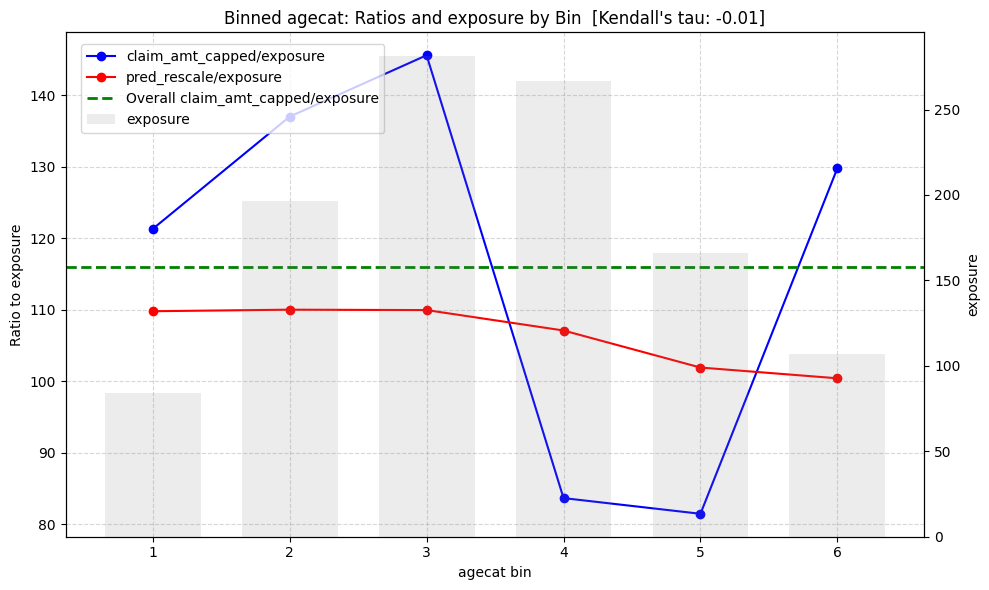


--- Predictiveness Plot for e_bill ---


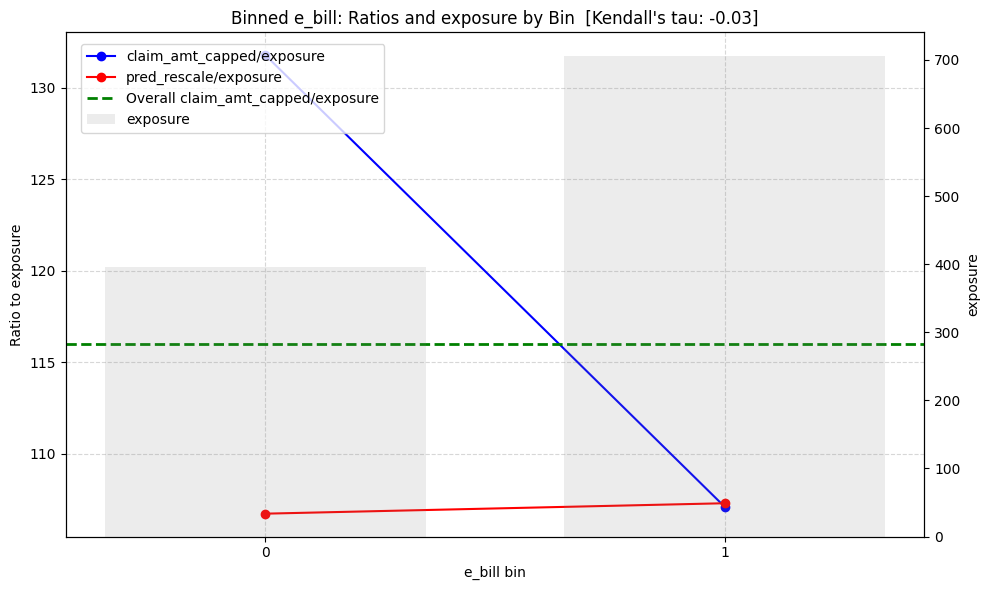


--- Predictiveness Plot for area ---


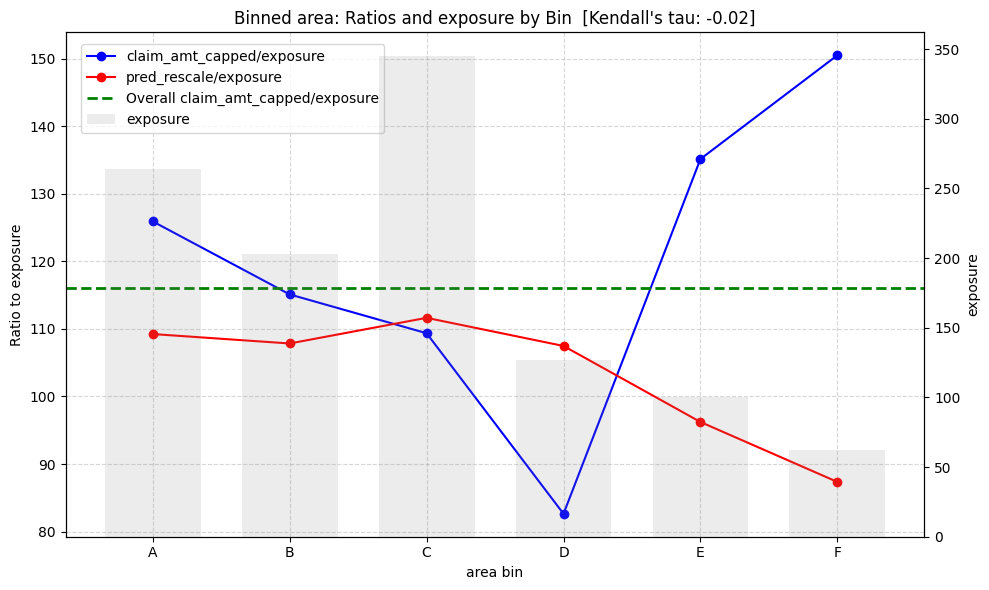


--- Predictiveness Plot for time_of_week_driven ---


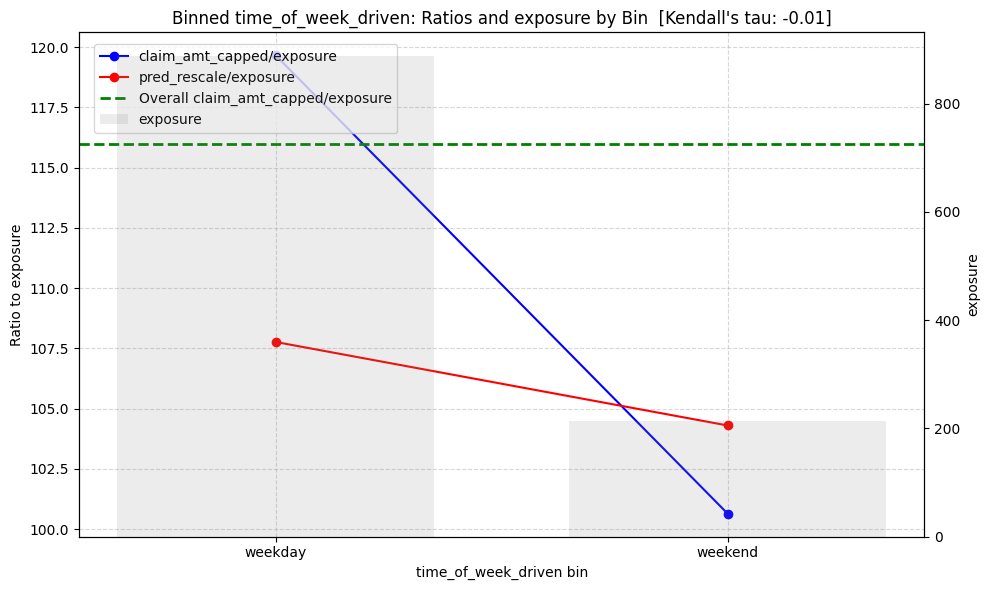


--- Predictiveness Plot for time_driven ---


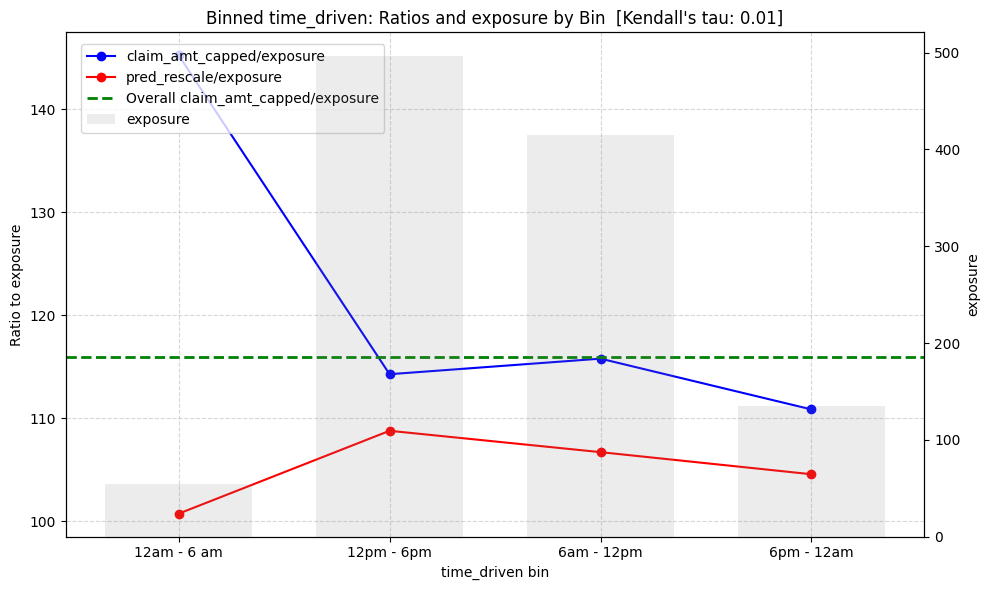


--- Predictiveness Plot for marital_status ---


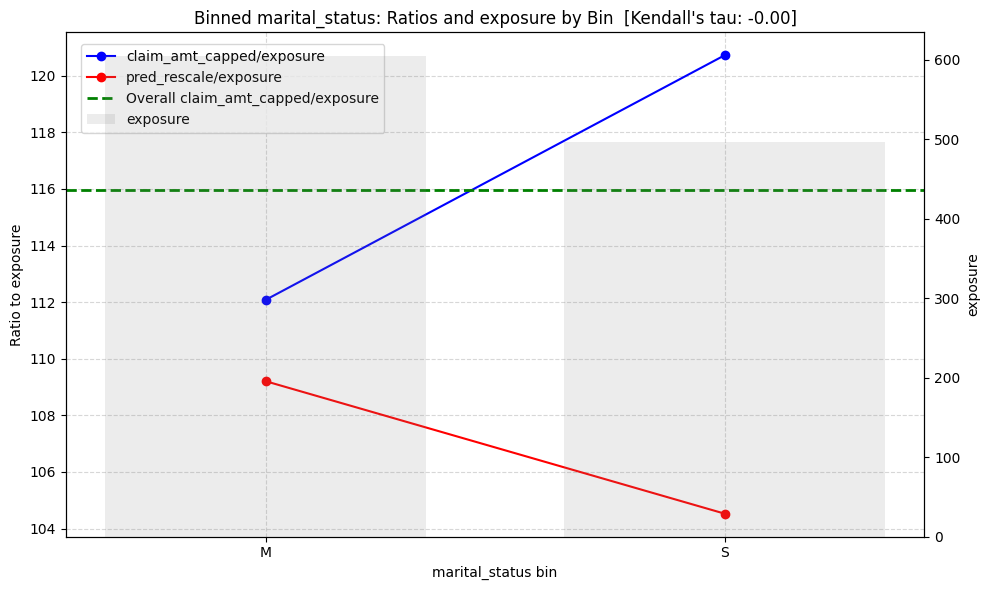


--- Predictiveness Plot for high_education_ind ---


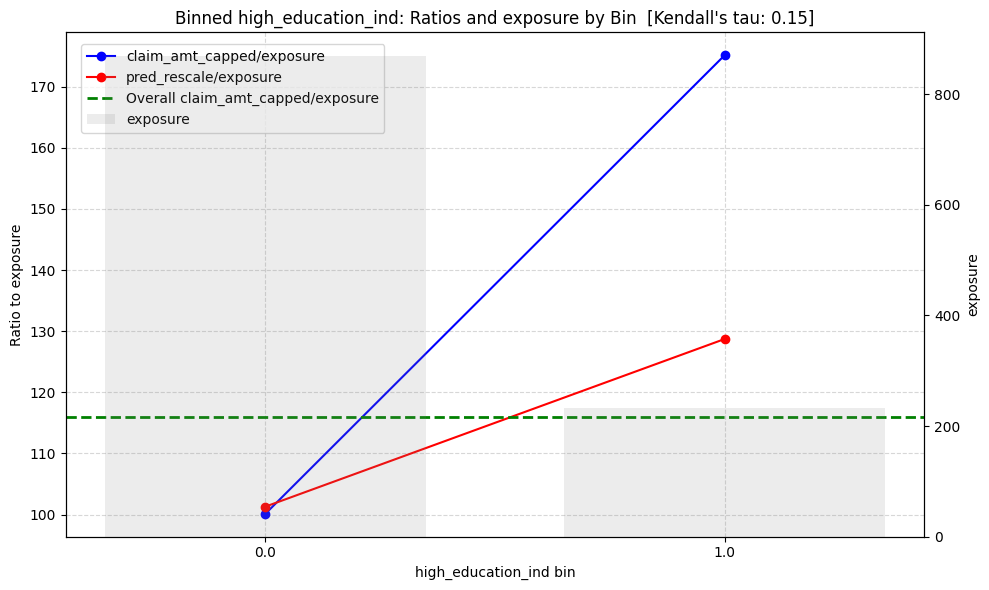


--- Predictiveness Plot for credit_score ---


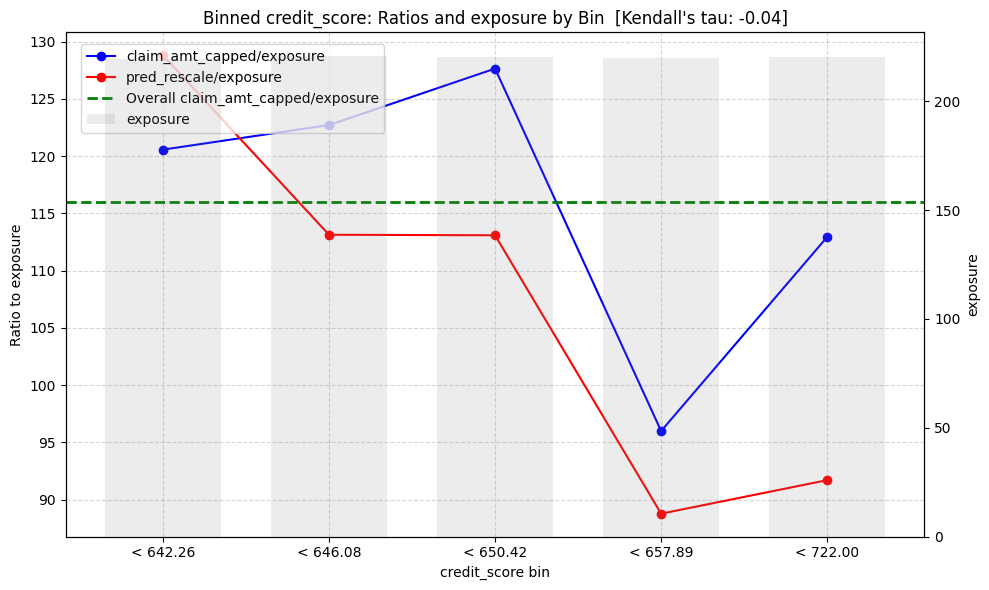


--- Predictiveness Plot for driving_history_score ---


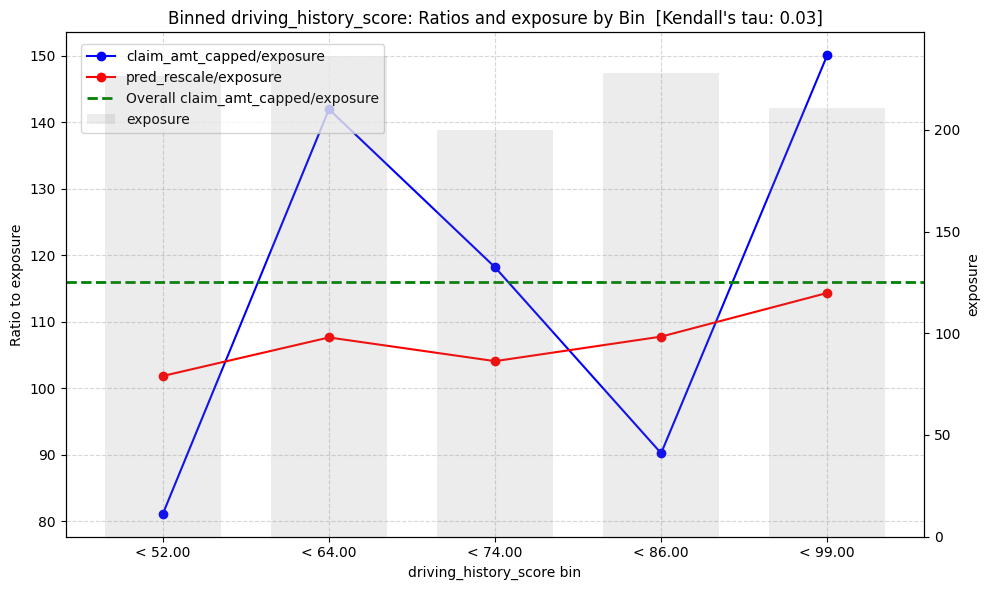

In [56]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
exp_var = 'exposure' 
var_1 = 'claim_amt_capped'     
var_2 = 'pred_rescale'   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=val_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

## <span style="color:red"><b><i>Model Selection</i></b></span>

<span style="color:red"><b><i>Task 2: Conduct hyper-parameters tunning on the tree-based model and compare the selected model performance with our base model above. Instead of doing a full panel grid search on all hyper-paramters. Let us consider an interactive hyper-parameter tunning approach to tune two to three hyper-parameters at a time. The benefits are three-folds.</i></b></span>

1. <span style="color:red"><b><i>Human charges and decisions are included.</i></b></span>
2. <span style="color:red"><b><i>Better computationally efficiency.</i></b></span>
3. <span style="color:red"><b><i>Hyper-parameter tunning according to their dependencies.</i></b></span>
4. <span style="color:red"><b><i>Better understand hyper-parameters of a tree-based model.</i></b></span>

<span style="color:red"><b><i>For interactive hypter-parameter tunning tuitorials, please refer to: 
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/.
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/</i></b></span>

<span style="color:red"><b><i>For sample output illustration, please refer to the plots below:</i></b></span>

<div style="background-color: #f8f8f8; padding: 10px;">
    <p style="color: black;">First, tune learning rate related hyper-parameters.</p>
    <img src="../images/4_grid_search_1.png" alt="Hypter-parameter tunning on learn rate related parameters" style="max-width:60%;">
    <p style="color: black;">Next, tune max depth and minimum rows per node.</p>
    <img src="../images/4_grid_search_2.png" alt="Hypter-parameter tunning on max depth and minimum rows" style="max-width:60%;">
</div>





<span style="color:red"><b><i>Task 3: Examine TabTPN - A Cutting Edge Transformer Based Model on Tabular Data. Specific to-dos: </i></b></span>
1. <span style="color:red"><b><i>Read and summarize the paper: https://arxiv.org/abs/2207.01848.</i></b></span>
2. <span style="color:red"><b><i>Examine TabTPN on our data and compare its performance with the other models built and the base model. Some sample code can be found on TabTPN's GitHub page: https://github.com/PriorLabs/TabPFN.</i></b></span>

<span style="color:red"><b><i>Task 4: Build another type of model (possible candidates: linear model and composite model, please do not build another tree-based models nor deep learning models) and compare its performance with the other models built and the base model above.

<span style="color:red"><b><i>One possible solution: Build a composite model to predict total loss. Specific to-dos: </i></b></span>

1. <span style="color:red"><b><i>Build a frequency model: Poisson Log-likelihood as the object function; 'claim_cnt' column as the target variable.</i></b></span> 
2. <span style="color:red"><b><i>Build a severity model: Gamma Log-likelihood as the object function; 'claim_sev_capped' column as the target variable; Remember to only use policy terms with positive losses.</i></b></span>  
3. <span style="color:red"><b><i>Derive the total loss predictions of each policy term via combining the predictions from the frequency model and severity model.</i></b></span> 
4. <span style="color:red"><b><i>Compare its performance with the other models built and the base model.</i></b></span> 

<span style="color:red"><b><i>Task 5: Conclude the pros and cons of the linear models, tree-based models (decision tree and ensemble tree models), deep learning models (use TabTPN as an example) and any other models you have considered in this project. </i></b></span>